In [7]:
import w4h
import pandas as pd
resources = w4h.get_resources(scope='local')
study_area = resources['study_area']
df = resources['well_data']
df = pd.read_csv(df)
df

c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\core.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


,ID,API_NUMBER,TABLE_NAME,WHO,INTERPRET_DATE,FORMATION,THICKNESS,TOP,BOTTOM,ID.1,LATITUDE,LONGITUDE,ELEVATION,geometry
0,0,1.216330e+11,WFORMATIONS,NaN,NaN,clay & silty clay,15.0,0.0,15.0,377397,38.520278,-90.218333,396.538940,POINT (-90.218333 38.520278)
1,1,1.216330e+11,WFORMATIONS,NaN,NaN,sand,96.0,15.0,111.0,377397,38.520278,-90.218333,396.538940,POINT (-90.218333 38.520278)
2,2,1.216330e+11,WFORMATIONS,NaN,NaN,crushed rock,3.0,0.0,3.0,376978,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917)
3,3,1.216330e+11,WFORMATIONS,NaN,NaN,clay,4.0,3.0,7.0,378246,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917)
4,4,1.216330e+11,WFORMATIONS,NaN,NaN,brown & gray sand,9.0,18.0,27.0,376978,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29800,29800,1.211923e+11,WFORMATIONS,NaN,NaN,dirt,3.0,0.0,3.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)
29801,29801,1.211923e+11,WFORMATIONS,NaN,NaN,coarse sand,15.0,25.0,40.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)
29802,29802,1.211923e+11,WFORMATIONS,NaN,NaN,sandy clay,8.0,5.0,13.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)
29803,29803,1.211923e+11,WFORMATIONS,NaN,NaN,rock at,0.0,94.0,94.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)


<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

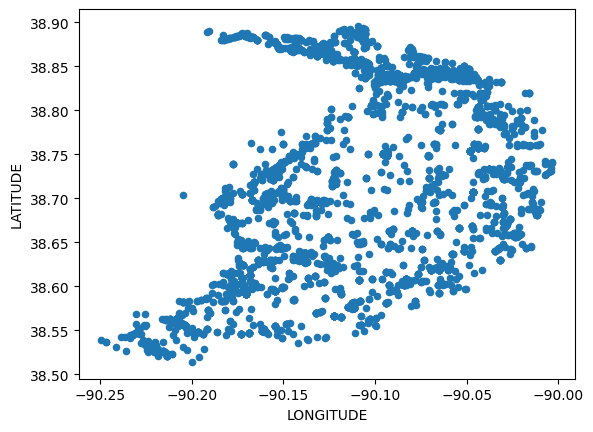

In [8]:
uniqueWellDF = df.drop_duplicates(subset='API_NUMBER')[["API_NUMBER", 'LATITUDE', "LONGITUDE", "ELEVATION"]].reset_index(drop=True)
uniqueWellDF.plot('LONGITUDE', "LATITUDE", kind='scatter')

In [190]:
import numpy as np
wellPtList = []
wellValueList = []
valueField = 'ELEVATION'
for i, well in uniqueWellDF.iterrows():
    wellPtList.append([well['LONGITUDE'], well["LATITUDE"]])
    wellValueList.append(well[valueField])
wellPtArr = np.array(wellPtList)

In [ ]:
from scipy.spatial import Voronoi
def natural_neighbor_interp(points, model_grid=None, layers=None, ):
    return Voronoi(points=points)
vClass = natural_neighbor_interp(wellPtArr)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_points',
 '_points',
 '_qhull',
 '_ridge_dict',
 '_update',
 'add_points',
 'close',
 'furthest_site',
 'max_bound',
 'min_bound',
 'ndim',
 'npoints',
 'point_region',
 'points',
 'regions',
 'ridge_dict',
 'ridge_points',
 'ridge_vertices',
 'vertices']

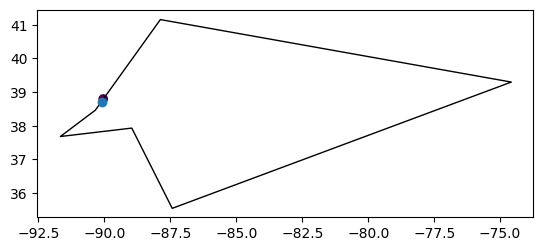

In [195]:
from shapely import Point, Polygon
verts = vClass.vertices

newPoint = Point([-90.1, 38.7])
for i, region in enumerate(vClass.regions):
    currPoly = Polygon([verts[v] for v in region if v!=-1])
    if currPoly.contains(newPoint):
        containingRegion = currPoly
        containingRegionIndex = i
        break

# Get all regions that touch containing region
regionAndAdjacents = [containingRegion]
regionIndices = [containingRegionIndex]
for i, region in enumerate(vClass.regions):
    touchCondition = containingRegion.touches(Polygon([verts[v] for v in region if v != -1]))
    # Add an adjacent condition? (region that touches a touching region)
    if touchCondition:
        regionAndAdjacents.append(Polygon([verts[v] for v in region if v != -1]))
        regionIndices.append(i)

# Now, get second layer of regions
regionAndAdjacents2 = regionAndAdjacents.copy()
for i, region in enumerate(regionAndAdjacents2):
    for j, newRegion in enumerate(vClass.regions):
        if region.touches(Polygon([verts[v] for v in newRegion if v != -1])) and j not in regionIndices:
            regionAndAdjacents.append(Polygon([verts[v] for v in newRegion if v != -1]))
            regionIndices.append(j)
    
# FIX THIS
nearPoints = [newPoint.coords[0]]
nearValues = [None]
vPR = list(vClass.point_region)
for ind in regionIndices:
    nearValues.append(wellValueList[vPR.index(ind)])
    nearPoints.append(vClass.points[vPR.index(ind)].tolist())
import matplotlib.pyplot as plt

x, y = zip(*nearPoints)
fig, ax = plt.subplots()
ax.scatter(x, y, c=nearValues)
import geopandas as gpd
regGS = gpd.GeoSeries(regionAndAdjacents, crs=4326)
#[reg.plot(ax=ax) for reg in regionAndAdjacents2]
regGS.plot(ax=ax, facecolor='#00000000', edgecolor='k')
ax.scatter(x=newPoint.xy[0], y=newPoint.xy[1])

In [167]:
point_index = 0
polyOfInterest = Polygon([nearbyVor.vertices[v] for v in nearbyVor.regions[nearbyVor.point_region[0]]])

In [194]:
nearbyVor = Voronoi(points=nearPoints)
import shapely.ops
import shapely.geometry
from scipy.spatial import voronoi_plot_2d
#voronoi_plot_2d(nearbyVor)
lines = [
shapely.geometry.LineString(nearbyVor.vertices[line])
for line in nearbyVor.ridge_vertices if -1 not in line
]

do_plot = False
# Generate polygons from the LineString objects
polygons = list(shapely.ops.polygonize(lines))
if do_plot:
    fig3, ax3 = plt.subplots()
    gpd.GeoSeries(polygons, crs=4326).plot(facecolor="#00000000", edgecolor='k', ax=ax3)
    x, y = zip(*nearPoints)
    ax3.scatter(x, y)
    gpd.GeoSeries([polyOfInterest], crs=4326).plot(facecolor="#00000000", edgecolor='r', ax=ax3)
    
# Get the "New" polygon (the one created for the interpolation point of interest)
polyOfInterest = Polygon([nearbyVor.vertices[v] for v in nearbyVor.regions[nearbyVor.point_region[0]]])

# Check which regions overlap and their areas
#### NEED TO KEEP TRACK OF REGIONS
intersectionAreas = []
for reg in regGS:
    if reg.intersects(polyOfInterest):
        intersectionAreas.append(polyOfInterest.intersection(reg).area)

# Calculate weights
np.array(intersectionAreas)/np.sum(intersectionAreas)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
nearPolygons = []
verts = nearbyVor.vertices
polyAreas = []
for reg in nearbyVor.regions:
    vertsList = [verts[v] for v in reg]
    # Maybe help make more valid? Does not seem to make a difference
    #if vertsList[0][0] != vertsList[-1][0]:
    #    vertsList.append(vertsList[0])
    polyTest = Polygon(vertsList)
    gpd.GeoSeries(polyTest, crs=4326).plot()
    if not polyTest.is_valid:
        print(polyTest.exterior.xy)
    nearPolygons.append(polyTest)
    
    polyOfInterest = Polygon([nearbyVor.vertices[v] for v in nearbyVor.regions[nearbyVor.point_region[0]]])
    polyAreas.append(polyOfInterest.intersection(polyTest))

nearPolyGDF = gpd.GeoSeries(nearPolygons, crs=4326)

fig2, ax2 = plt.subplots()
nearPolyGDF.plot(ax=ax2, facecolor='#00000000', edgecolor='k')
[ax2.scatter(pt[0], pt[1]) for pt in nearPoints]

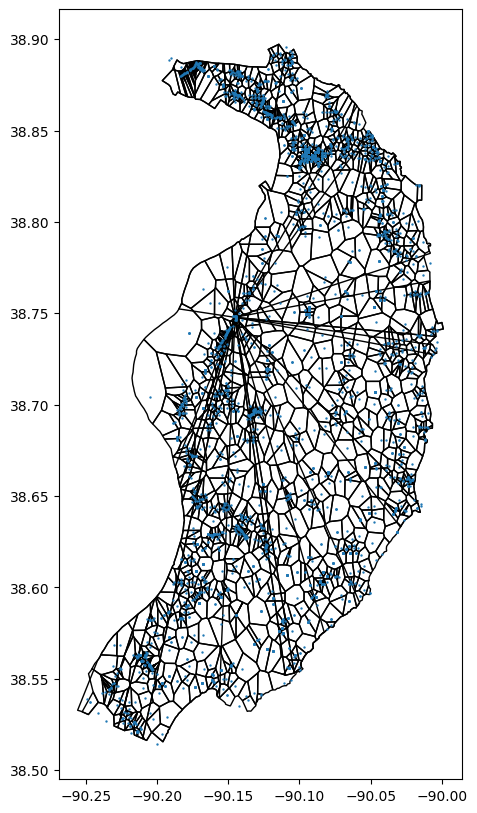

In [ ]:
from shapely import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
fig, ax = plt.subplots(figsize=(10,10))

geomList = []
verts = vClass.vertices
for region in vClass.regions:
    if len(region)>0:
        #region.append(region[0])

        currPoly = Polygon([verts[v] for v in region])
        if currPoly.is_valid:
            geomList.append(currPoly)

saCoords = Polygon([Point([-90.14341, 38.76749]), Point([-90.05592, 38.71129]), Point([-90.10095, 38.64567]), Point([-90.17643, 38.70627])])

sa = gpd.read_file(resources['study_area']).to_crs(4326)
test = gpd.GeoSeries(geomList, crs=4326)
test = test.clip(sa)
test.plot(edgecolor='k', ax=ax, facecolor="#00000000")
ax.scatter(x=uniqueWellDF['LONGITUDE'], y=uniqueWellDF['LATITUDE'], s=0.5)
